In [1]:

# Machine Learning Code, last edited March 12th, 2024

# import packages
import pandas as pd
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import pickle

print("""
  __  __   _         _____   _____
 |  \/  | | |       / ____| |  __ \\
 | \  / | | |      | |      | |__) |
 | |\/| | | |      | |      |  ___/
 | |  | | | |____  | |____  | |
 |_|  |_| |______|  \_____| |_|
 """)
print("\nRunning Scikit-learn version " + str(sklearn.__version__) + "\n")

<>:14: SyntaxWarning: invalid escape sequence '\/'
<>:14: SyntaxWarning: invalid escape sequence '\/'
/var/folders/vj/ybz4zyl541v64jxvktjgnb3m0000gp/T/ipykernel_25499/928883549.py:14: SyntaxWarning: invalid escape sequence '\/'
  print("""



  __  __   _         _____   _____
 |  \/  | | |       / ____| |  __ \
 | \  / | | |      | |      | |__) |
 | |\/| | | |      | |      |  ___/
 | |  | | | |____  | |____  | |
 |_|  |_| |______|  \_____| |_|
 

Running Scikit-learn version 1.3.0



In [2]:
import os
os.chdir('/Users/aboth/Desktop/gordon/mlcpproject')

In [3]:
pwd

'/Users/aboth/Desktop/gordon/mlcpproject'

In [4]:
X_df = pd.read_excel('contact_data_by_cp.xlsx')

In [5]:
X_df

,,elem1_n,elem2_id,elem2_n,contact1_id,contact1_homo,contact1_hetero,contact2_id,contact2_homo,contact2_hetero,length,voronoi_area,voronoi_volume,vorovol_at_rad,vorovol_en,vorovol_at_rad_en,contact_CP,cp_voxels,struct_type
0,Cu,4,Mg,2,Mg,4,12,Mg,4,12,2.9732,1.993639,0.987913,1.975826,1.472476,2.944953,-0.042848,14227.285714,Laves(cub)#MgCu2
1,Au,3,Li,1,Au,8,4,Li,0,12,2.8166,2.804741,1.316620,2.716801,4.750436,9.802365,-0.042831,743.416667,Auricupride#AuCu3
2,Mg,4,Zn,8,Mg,4,12,Mg,4,12,3.1047,2.137953,1.106276,2.271905,1.732016,3.556956,-0.042594,10171.000000,Laves(2H)#MgZn2
3,Mg,4,Zn,8,Mg,4,12,Mg,4,12,3.0892,2.201323,1.133377,2.327561,1.774446,3.644093,-0.042525,10865.285714,Laves(2H)#MgZn2
4,Ni,5,Sc,1,Ni,9,3,Ni,9,3,2.6718,1.567921,0.698187,1.267003,1.655452,3.004155,-0.041951,8107.666667,CaCu5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,Nb,1,Ni,3,Ni,8,4,Ni,8,4,2.5265,2.437573,1.026429,1.535827,2.288683,3.424515,0.031553,18744.500000,TiAl3
2633,Ta,4,Mn,8,Mn,6,6,Mn,6,6,2.2790,3.071342,1.166616,2.167599,2.351591,4.369310,0.032610,11284.000000,Laves(2H)#MgZn2
2634,Mg,8,Ni,16,Ni,6,6,Ni,6,6,2.3470,2.612964,1.022084,2.057610,2.166458,4.361408,0.032683,33627.833333,Laves(4H)#MgNi2
2635,Ag,2,N,6,N,10,8,N,14,4,1.1762,7.295177,1.430093,0.702333,3.153506,1.548719,0.034660,75506.000000,KN3


In [6]:
y = X_df.pop('contact_CP')

In [7]:
#parity plot function
def parity_plot(x,y,title):
    pad = 0.001
    std = np.std(abs(y-x.to_numpy()))
    x1 = np.linspace(min(x)-pad,max(x)+pad)
    x2 = [list(x)[i] for i in range(len(x)) if list(abs(y-x.to_numpy()))[i] > 3*std]
    y2 = [list(y)[i] for i in range(len(x)) if list(abs(y-x.to_numpy()))[i] > 3*std]
    ymin,ymax = float(x.min())-pad,float(x.max())+pad
    return(std)

# function that adds elemental information to dataframe
def get_element_feature_df_vv_en(input_df):
    element_df = pd.read_excel('element_data.xlsx') # read in the element feature reference spreadsheet
    element_df.set_index('Symbol',inplace=True) # re-index the reference spreadsheet by element name
    element_df_names = list(element_df.columns) # create a list of names of all elements in the reference sheet
    column_names = [name + '_element1' for name in list(element_df.columns)]+[name + '_element2' for name in list(element_df.columns)]+[name + '_contact1' for name in list(element_df.columns)]+[name + '_contact2' for name in list(element_df.columns)]+['element1_n','element2_n','contact1_homo','contact1_hetero','contact2_homo','contact2_hetero','length','vorovol_en']
    feature_df = pd.DataFrame(columns = column_names) # create an empty dataframe with the appropriate column names
    for n in tqdm(range(len(input_df)), bar_format='{l_bar}{bar:73}{r_bar}{bar:-73b}'):
        in_list = input_df.iloc[n]
        element_list = [in_list[0],in_list[2],in_list[4],in_list[7]]
        # create list of the features for each element in the contact
        features = [element_df.loc[element].values for element in element_list]
        # write each row of the dataframe based on each entry
        l1 = list(features[0])+list(features[1])+list(features[2])+list(features[3])
        l2 = [in_list[1],in_list[3],in_list[5],in_list[6],in_list[8],in_list[9],in_list[10],in_list[14]]
        feature_df.loc[n] = l1 + l2
    return feature_df

In [8]:
# add descriptors to the DF based on element identity, CN, bond len., # of homo/heteroatomic contacts, and voronoi descriptors
X_final = get_element_feature_df_vv_en(X_df)

  0%|                                                                         | /var/folders/vj/ybz4zyl541v64jxvktjgnb3m0000gp/T/ipykernel_25499/1521488812.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  element_list = [in_list[0],in_list[2],in_list[4],in_list[7]]
/var/folders/vj/ybz4zyl541v64jxvktjgnb3m0000gp/T/ipykernel_25499/1521488812.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  l2 = [in_list[1],in_list[3],in_list[5],in_list[6],in_list[8],in_list[9],in_list[10],in_list[14]]
/var/folders/vj/ybz4zyl541v64jxvktjgnb3m0000gp/T/ipykernel_25499/1521488812.py:20: FutureWarning: Series.__getitem__ treating ke

In [35]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [39]:
X

,length,vorovol_en,Sum Metalic Radii,Metalic Volume,Length Cubed,Pauling EN Range,Diff Len,Diff Vorovol,Diff Metvol,Atomic_Number_composition_avg,Atomic_Number_composition_std,Atomic_Weight_composition_avg,Atomic_Weight_composition_std,Metallic Radii_composition_avg,Metallic Radii_composition_std,Period_composition_avg,Period_composition_std,Group_composition_avg,Group_composition_std,Mendeleev Number_composition_avg,Mendeleev Number_composition_std,Pauling Electronegativity_composition_avg,Pauling Electronegativity_composition_std,number of valence electrons_composition_avg,number of valence electrons_composition_std,valence s_composition_avg,valence s_composition_std,valence p_composition_avg,valence p_composition_std,valence d_composition_avg,valence d_composition_std,1st ionization potential (kJ/mol)_composition_avg,1st ionization potential (kJ/mol)_composition_std,electron affinity_composition_avg,electron affinity_composition_std,DFT LDA Etot_composition_avg,DFT LDA Etot_composition_std,Atomic_Number_contact_avg,Atomic_Number_contact_std,Atomic_Weight_contact_avg,Atomic_Weight_contact_std,Metallic Radii_contact_avg,Metallic Radii_contact_std,Period_contact_avg,Period_contact_std,Group_contact_avg,Group_contact_std,Mendeleev Number_contact_avg,Mendeleev Number_contact_std,Pauling Electronegativity_contact_avg,Pauling Electronegativity_contact_std,number of valence electrons_contact_avg,number of valence electrons_contact_std,valence s_contact_avg,valence s_contact_std,valence p_contact_avg,valence p_contact_std,valence d_contact_avg,valence d_contact_std,1st ionization potential (kJ/mol)_contact_avg,1st ionization potential (kJ/mol)_contact_std,electron affinity_contact_avg,electron affinity_contact_std,DFT LDA Etot_contact_avg,DFT LDA Etot_contact_std,contacts_avg_homo,contacts_std_homo,contacts_avg_hetero,contacts_std_hetero
0,2.9732,1.472476,3.20,8.192000,26.282845,0.00,0.2268,-24.810369,-18.090845,23.333333,8.013877,50.465667,18.498385,138.666667,15.084945,3.666667,0.471405,8.000000,4.242641,65.333333,1.885618,1.703333,0.278129,8.000000,4.242641,1.333333,0.471405,0.00,0.000000,6.666667,4.714045,742.666667,3.299832,66.156667,75.064099,-1158.237043,678.184443,12.0,0.0,24.30500,0.00000,160.0,0.0,3.0,0.0,2.0,0.0,68.0,0.0,1.31,0.00,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,738.0,0.0,-40.0000,0.0000,-199.139406,0.000000,4.0,0.0,12.0,0.0
1,2.8166,4.750436,3.01,6.855877,22.344751,1.56,0.1934,-17.594315,-15.488874,60.000000,32.908965,149.460155,82.283473,147.250000,5.629165,5.000000,1.732051,8.500000,4.330127,49.750000,28.145826,2.150000,0.675500,8.500000,4.330127,1.000000,0.000000,0.00,0.000000,7.500000,4.330127,797.500000,160.214700,181.968400,70.630607,-13397.427006,7730.773112,41.0,38.0,101.95377,95.01277,150.5,6.5,4.0,2.0,6.0,5.0,33.5,32.5,1.76,0.78,6.0,5.0,1.0,0.0,0.0,0.0,5.0,5.0,705.0,185.0,141.1898,81.5572,-8934.063069,8926.727874,4.0,4.0,8.0,4.0
2,3.1047,1.732016,3.20,8.192000,29.926707,0.00,0.0953,-28.194691,-21.734707,24.000000,8.485281,51.695000,19.367655,144.666667,10.842304,3.666667,0.471405,8.666667,4.714045,68.666667,0.471405,1.536667,0.160278,8.666667,4.714045,2.000000,0.000000,0.00,0.000000,6.666667,4.714045,850.000000,79.195959,-53.333333,9.428090,-1250.762369,743.609728,12.0,0.0,24.30500,0.00000,160.0,0.0,3.0,0.0,2.0,0.0,68.0,0.0,1.31,0.00,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,738.0,0.0,-40.0000,0.0000,-199.139406,0.000000,4.0,0.0,12.0,0.0
3,3.0892,1.774446,3.20,8.192000,29.480719,0.00,0.1108,-27.706273,-21.288719,24.000000,8.485281,51.695000,19.367655,144.666667,10.842304,3.666667,0.471405,8.666667,4.714045,68.666667,0.471405,1.536667,0.160278,8.666667,4.714045,2.000000,0.000000,0.00,0.000000,6.666667,4.714045,850.000000,79.195959,-53.333333,9.428090,-1250.762369,743.609728,12.0,0.0,24.30500,0.00000,160.0,0.0,3.0,0.0,2.0,0.0,68.0,0.0,1.31,0.00,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,738.0,0.0,-40.0000,0.0000,-199.139406,0.000000,4.0,0.0,12.0,0.0
4,2.6718,1.655452,2.50,3.906250,19.072685,0.00,-0.1718,-17.417233,-15.166435,26.83333

In [38]:
X_df

,,elem1_n,elem2_id,elem2_n,contact1_id,contact1_homo,contact1_hetero,contact2_id,contact2_homo,contact2_hetero,length,voronoi_area,voronoi_volume,vorovol_at_rad,vorovol_en,vorovol_at_rad_en,cp_voxels,struct_type
0,Cu,4,Mg,2,Mg,4,12,Mg,4,12,2.9732,1.993639,0.987913,1.975826,1.472476,2.944953,14227.285714,Laves(cub)#MgCu2
1,Au,3,Li,1,Au,8,4,Li,0,12,2.8166,2.804741,1.316620,2.716801,4.750436,9.802365,743.416667,Auricupride#AuCu3
2,Mg,4,Zn,8,Mg,4,12,Mg,4,12,3.1047,2.137953,1.106276,2.271905,1.732016,3.556956,10171.000000,Laves(2H)#MgZn2
3,Mg,4,Zn,8,Mg,4,12,Mg,4,12,3.0892,2.201323,1.133377,2.327561,1.774446,3.644093,10865.285714,Laves(2H)#MgZn2
4,Ni,5,Sc,1,Ni,9,3,Ni,9,3,2.6718,1.567921,0.698187,1.267003,1.655452,3.004155,8107.666667,CaCu5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,Nb,1,Ni,3,Ni,8,4,Ni,8,4,2.5265,2.437573,1.026429,1.535827,2.288683,3.424515,18744.500000,TiAl3
2633,Ta,4,Mn,8,Mn,6,6,Mn,6,6,2.2790,3.071342,1.166616,2.167599,2.351591,4.369310,11284.000000,Laves(2H)#MgZn2
2634,Mg,8,Ni,16,Ni,6,6,Ni,6,6,2.3470,2.612964,1.022084,2.057610,2.166458,4.361408,33627.833333,Laves(4H)#MgNi2
2635,Ag,2,N,6,N,10,8,N,14,4,1.1762,7.295177,1.430093,0.702333,3.153506,1.548719,75506.000000,KN3


In [10]:
# Add new features
X = X_final.copy()
X['Sum Metalic Radii'] = (X['Metallic Radii_contact1']+X['Metallic Radii_contact2'])/100
X['Metalic Volume'] = (X['Metallic Radii_contact1']/100)**3+(X['Metallic Radii_contact2']/100)**3
X['Length Cubed'] = X['length']**3
X['Pauling EN Range'] = abs(X['Pauling Electronegativity_contact1']-X['Pauling Electronegativity_contact2'])
X['Diff Len'] = X['Sum Metalic Radii']-X['length']
X['Diff Vorovol'] = X['vorovol_en']-X['Length Cubed']
X['Diff Metvol'] = X['Metalic Volume']-X['Length Cubed']

In [11]:
# convert ["element1", "element2"] data to ["avg", "std_dev"] format. This allows for the addition of ternaries
# Also, weight the average and std_dev by the stoichiometry
cols = X.columns
for i in range(14):
    X[cols[i][:-8]+"composition_avg"] = (X[cols[i]]*X['element1_n'] + X[cols[i+14]]*X['element2_n'])/(X['element1_n'] + X['element2_n'])
    X[cols[i][:-8]+"composition_std"] = np.sqrt((X['element1_n']*(X[cols[i]] - X[cols[i][:-8]+"composition_avg"])**2 + (X['element2_n']*(X[cols[i+14]] - X[cols[i][:-8]+"composition_avg"])**2))/(X['element1_n'] + X['element2_n']))
X = X.iloc[:,28:]
cols = X.columns
for i in range(14):
    X[cols[i][:-8]+"contact_avg"] = (X[cols[i]] + X[cols[i+14]])/2
    X[cols[i][:-8]+"contact_std"] = abs(X[cols[i]] - X[cols[i+14]])/2
X = X.iloc[:,28:]
cols = X.columns
for i in range(2):
    X["contacts_avg_"+cols[2+i][9:]] = (X[cols[2+i]] + X[cols[4+i]])/2
    X["contacts_std_"+cols[2+i][9:]] = abs(X[cols[2+i]] - X[cols[4+i]])/2
    X = X.drop(columns=[cols[2+i], cols[4+i]])
X = X.iloc[:,2:]

In [12]:
# split data ordered by CP so that 8 data points go to training, one goes to testing, and one goes to validation.
X_train = pd.DataFrame(columns=X.columns)
X_test = pd.DataFrame(columns=X.columns)
X_val = pd.DataFrame(columns=X.columns)
y_train = pd.Series(dtype="float", name="contact_CP")
y_test = pd.Series(dtype="float", name="contact_CP")
y_val = pd.Series(dtype="float", name="contact_CP")


In [13]:

#"""
# This splits the data evenly, taking every 10n-th data point for validation, 10n-th+1 for testing, and the remaining 8 for training
for i in tqdm(range(len(X.index)), bar_format='{l_bar}{bar:73}{r_bar}{bar:-73b}'):
    x_row = X.iloc[i]
    y_row = y.iloc[i]
    if (i)%10 == 0: #0, 10, 20, 30, ...
        X_val.loc[len(X_test.index)] = x_row
        y_val.loc[len(y_test.index)] = y_row
    elif (i+1)%10 == 0: #9, 19, 29, 39, ...
        X_test.loc[len(X_val.index)] = x_row
        y_test.loc[len(y_val.index)] = y_row
    else: # 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, ...
        X_train.loc[len(X_train.index)] = x_row
        y_train.loc[len(y_train.index)] = y_row

"""
X_test = X.iloc[:294]
X_val = X.iloc[294:536]
X_train = X.iloc[536:]
y_test = y.iloc[:294]
y_val = y.iloc[294:536]
y_train = y.iloc[536:]
#"""


100%|█████████████████████████████████████████████████████████████████████████| 


'\nX_test = X.iloc[:294]\nX_val = X.iloc[294:536]\nX_train = X.iloc[536:]\ny_test = y.iloc[:294]\ny_val = y.iloc[294:536]\ny_train = y.iloc[536:]\n#'

In [14]:
# prepare target dataframes
threshold1 =  0.0000 # define threshold (0 = split between overall + and - CPs)
threshold2 = -0.0035 # define threshold (0 = split between overall + and - CPs)
y_train_df,y_test_df,y_val_df = pd.DataFrame(y_train),pd.DataFrame(y_test),pd.DataFrame(y_val)


In [15]:
# create new columns in target dataframes for binary classification
y_train_df['over'] = np.where(y_train_df['contact_CP']>threshold1, 1, 0) + np.where(y_train_df['contact_CP']>threshold2, 1, 0)
y_test_df['over'] = np.where(y_test_df['contact_CP']>threshold1, 1, 0) + np.where(y_test_df['contact_CP']>threshold2, 1, 0)
y_val_df['over'] = np.where(y_val_df['contact_CP']>threshold1, 1, 0) + np.where(y_val_df['contact_CP']>threshold2, 1, 0)


In [16]:
# train and fit RFC model
rfc = RandomForestClassifier(
    n_estimators=300,
    max_features=20,
    random_state=0,
    max_depth=15
)
rfc.fit(X_train,y_train_df['over'])

RandomForestClassifier(max_depth=15, max_features=20, n_estimators=300,
                       random_state=0)

In [17]:
# predict target values for validation set
y_pred_RFC = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train)
y_val_pred = rfc.predict(X_val)

print('')

In [18]:
# calculate and print CV score, show confusion matrix
scores = cross_val_score(rfc,X_test,y_test_df['over'],cv=10)


In [19]:
# calculate and print CV score, show confusion matrix
scores2 = cross_val_score(rfc,X_val,y_val_df['over'],cv=10)

In [20]:
# save trained model in a pickle file
f = open('rfc.pickle', 'wb')
pickle.dump(rfc, f)
f.close()


In [21]:
# Identify the top X most important features
feat_import = rfc.feature_importances_
imp_df = pd.DataFrame(columns=X_train.columns)
imp_df.loc[0]=feat_import
imp_df = imp_df.transpose().sort_values(by=0,ascending=False).head(30).transpose()

In [22]:
# Add classifier predictions to the dataframe used for the regressor.
X_train_rfr = X_train.join(pd.DataFrame(rfc.predict(X_train),index=X_train.index,columns=["rfc_predictions"]))
X_test_rfr = X_test.join(pd.DataFrame(rfc.predict(X_test),index=X_test.index,columns=["rfc_predictions"]))
X_val_rfr = X_val.join(pd.DataFrame(rfc.predict(X_val),index=X_val.index,columns=["rfc_predictions"]))


In [23]:
#rfr = RandomForestRegressor(n_estimators=300,max_features=15,random_state=0) # define the parameters of the RFR model
rfr = ExtraTreesRegressor(
    n_estimators = 300,
    max_features = 30,
    random_state = 0,
    max_depth = 20,
)
rfr.fit(X_train_rfr,y_train) # fit the RFR model to the training data
y_pred = rfr.predict(X_test_rfr) # predict target values for the validation set
y_val_pred = rfr.predict(X_val_rfr) # predict target values for the validation set


In [24]:
#============================================================================================

# TESTING
mae = round(round(mean_absolute_error(y_test, y_pred)*100,3)/100,5) # calculate the MAE of the validation predictions
rmse = round(round(np.sqrt(mean_squared_error(y_test, y_pred))*100,3)/100,5) # calculate the RMSE of the validation predictions
r2 = round(r2_score(y_test, y_pred,),5) # calculate R2 score

confussion = [0,0,0,0]
for i in range(len(y_test.index)):
    if y_test.iloc[i] > 0 and y_pred[i] > 0: # guess positive, correct
        confussion[0]+=1
    elif y_test.iloc[i] < 0 and y_pred[i] < 0: # guess negative, correct
        confussion[2]+=1
    elif y_test.iloc[i] > 0 and y_pred[i] < 0: # guess negative, wrong
        confussion[1]+=1
    else: # guess positive, wrong
        confussion[3]+=1

# graph the parity plot
std = round(parity_plot(y_test,y_pred,'full feature set'), 5)
#print(confussion)

#============================================================================================


In [25]:

# VALIDATION
mae2 = round(round(mean_absolute_error(y_val, y_val_pred)*100,3)/100,5) # calculate the MAE of the validation predictions
rmse2 = round(round(np.sqrt(mean_squared_error(y_val, y_val_pred))*100,3)/100,5) # calculate the RMSE of the validation predictions
r22 = round(r2_score(y_val, y_val_pred,),5) # calculate R2 score

confussion = [0,0,0,0]
for i in range(len(y_val.index)):
    if y_val.iloc[i] > 0 and y_val_pred[i] > 0: # guess positive, correct
        confussion[0]+=1
    elif y_val.iloc[i] < 0 and y_val_pred[i] < 0: # guess negative, correct
        confussion[2]+=1
    elif y_val.iloc[i] > 0 and y_val_pred[i] < 0: # guess negative, wrong
        confussion[1]+=1
    else: # guess positive, wrong
        confussion[3]+=1

# graph the parity plot
std2 = round(parity_plot(y_val,y_val_pred,'full feature set'), 5)
#print(confussion)

f = open('rfr.pickle', 'wb')
pickle.dump(rfr, f)
f.close()

# Identify the top X most important features
feat_import = rfr.feature_importances_
imp_df = pd.DataFrame(columns=X_train_rfr.columns)
imp_df.loc[0]=feat_import
imp_df = imp_df.transpose().sort_values(by=0,ascending=False).head(30).transpose()

# Print Summary Data
print('')
print('\t\tTESTING\t\tVALIDATION')
print(f"Classifier:\t{round(scores.mean(),4)}\t\t{round(scores2.mean(),4)}")
print(f'MAE:\t\t{round(mae,4)}\t\t{round(mae2,4)}')
print(f'RMSE:\t\t{round(rmse,4)}\t\t{round(rmse2,4)}')
print(f'R2:\t\t{round(r2,4)}\t\t{round(r22,4)}')
print(f'STDDEV:\t\t{round(std,4)}\t\t{round(std2,4)}')


		TESTING		VALIDATION
Classifier:	0.689		0.7006
MAE:		0.0025		0.0021
RMSE:		0.005		0.0038
R2:		0.7075		0.8413
STDDEV:		0.0044		0.0032


In [26]:
#parity plot function
import matplotlib.pyplot as plt
def parity_plot_go(x,y,title):
    pad = 0.001
    std = np.std(abs(y-x.to_numpy()))
    x1 = np.linspace(min(x)-pad,max(x)+pad)
    x2 = [list(x)[i] for i in range(len(x)) if list(abs(y-x.to_numpy()))[i] > 3*std]
    y2 = [list(y)[i] for i in range(len(x)) if list(abs(y-x.to_numpy()))[i] > 3*std]
    ymin,ymax = float(x.min())-pad,float(x.max())+pad
    plt.scatter(x,y)
    plt.plot(x1,x1)
    plt.title('Parity Plot: '+title)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    print(f'R^2 score: {r2_score(x,y)}')
    return(std)

R^2 score: 0.8412856408346745


0.0031929048940475273

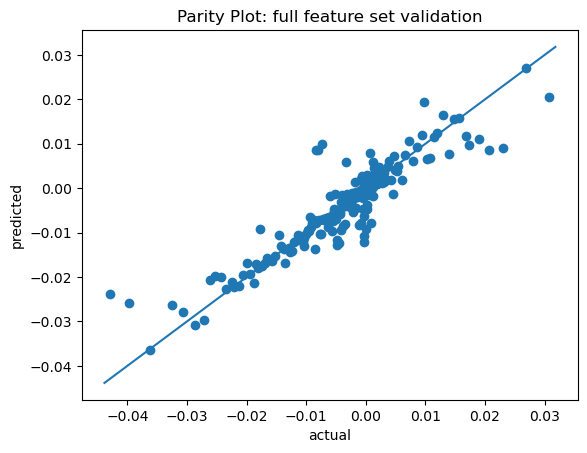

In [27]:
parity_plot_go(y_val,y_val_pred,'full feature set validation')

R^2 score: 0.7074720976065287


0.004380892541819746

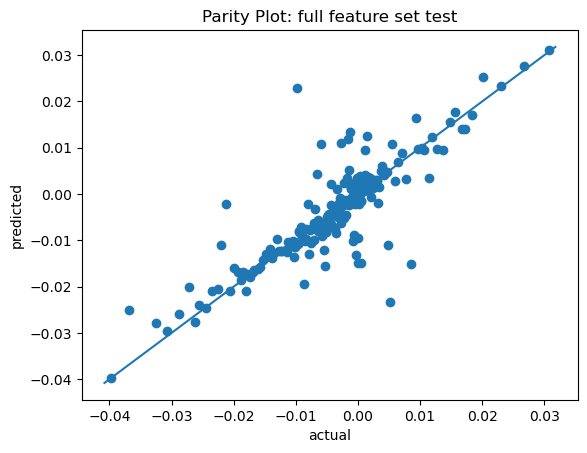

In [28]:
parity_plot_go(y_test,y_pred,'full feature set test')

R^2 score: 0.9999725739559931


4.424697647871485e-05

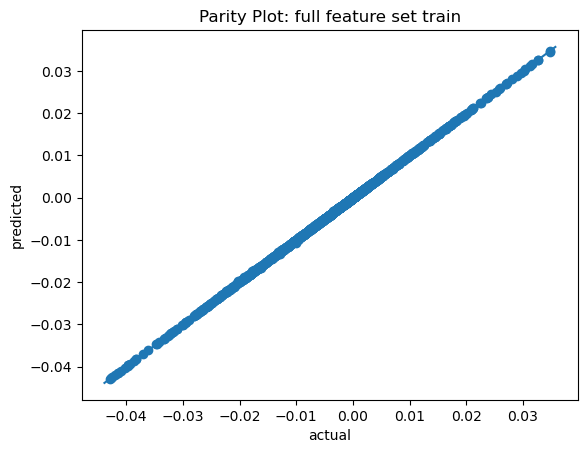

In [29]:
y_train_rfrpred = rfr.predict(X_train_rfr) # predict target values for the validation set

parity_plot_go(y_train,y_train_rfrpred,'full feature set train')